## AI2 Reasoning Challenge (ARC) 2018



### 1.Business/Real-world Problem:

#### 1.1 Source:
This problem is given by the Allen Institute for Artificial Intelligence (AI2) solutions to several question-answering (QA) tasks.
Source:https://allenai.org/data/arc


#### 1.2 Problem Statement
Datasets are increasingly driving progress in AI, resulting
in impressive solutions to several question-answering (QA)
tasks (e.g., Rajpurkar et al., 2016; Joshi et al., 2017). However, many of these datasets focused on retrieval-style tasks,
where surface-level cues alone were usually sufficient to
identify an answer. This has not encouraged progress on
questions requiring reasoning, use of commonsense knowledge, or other advanced methods for deeper text comprehension. The challenge presented here, called ARC (AI2 Reasoning Challenge), aims to address this limitation by posing
questions that are hard to answer with simple baselines.

A new dataset of 7,787 genuine grade-school level, multiple-choice science questions, assembled to encourage research in advanced question-answering. The dataset is partitioned into a Challenge Set and an Easy Set, where the former contains only questions answered incorrectly by both a retrieval-based algorithm and a word co-occurrence algorithm. They have also given us a corpus of over 14 million science sentences relevant to the task, and an implementation of three neural baseline models for this dataset. They posed ARC as a challenge to the community.

What we need to do : We have questions given and on the based of these question and 14 million science sentences(using it is optional) we need to find the valid answer.



What we achieve with this case study : In this Case study we will be getting the correct answer from the multiple choice answers

### 1.3. Real-world/Business objectives and constraints
⦁ Maximize the scoring:

⦁ There is no strict latency requirement:But as the problem is for solving question answer in exam so,we need to answer each question within a minutes.

⦁ There is no strict interpretability requirement.

## 2. Machine Learning Problem
### 2.1. Data Overview:

Source:https://allenai.org/data/arc

The ARC dataset consists of 7,787 science exam questions drawn from a variety of sources, including science questions provided under license by a research partner affiliated with AI2. These are text-only, English language exam questions that span several grade levels as indicated in the files. Each question has a multiple choice structure (typically 4 answer options). The questions are sorted into a Challenge Set of 2,590 “hard” questions (those that both a retrieval and a co-occurrence method fail to answer correctly) and an Easy Set of 5,197 questions. Each are pre-split into Train, Development, and Test sets as follows:

Challenge Train: 1,119
Challenge Dev: 299
Challenge Test: 1,172
Easy Train: 2,251
Easy Dev: 570
Easy Test: 2,376
Each set is provided in two formats, CSV and JSON. The CSV files contain the full text of the question and its answer options in one cell. The JSON files contain a split version of the question, where the question text has been separated from the answer options programatically.

 They have also given us a corpus of over 14 million science sentences relevant to the task, and an implementation of three neural baseline models for this dataset.



### 2.2. Mapping the real-world problem to an ML problem:
#### Information Retrieval (IR) Solver:
The first filter we apply is the IR solver from Clark et al. (2016), The IR solver uses the Waterloo corpus from (Clark et al., 2016), a Web-based corpus of 5×1010
tokens (280GB). The solver searches to see if the question
q along with an answer option is explicitly stated in the corpus, and returns the confidence that such a statement was
found. To do this, for each answer option a_i
, it sends q + a_i
as a query to a search engine (we use Elasticsearch), and returns the search engine’s score for the top retrieved sentence
s where s also has at least one non-stopword overlap with q,
and at least one with a_i
; this ensures s has some relevance
to both q and a_i
. This is repeated for all options a_i
to score
them all, and the option with the highest score selected.

#### The Pointwise Mutual Information (PMI) Solver:
 The second filter we apply is the PMI solver, also from Clark
et al. (2016), again described here for completeness. This
uses the same corpus as the IR solver, and formalizes a way
of computing and applying associational knowledge. Given
a question q and an answer option ai
, it uses PMI or pointwise mutual information (Church and Hanks, 1989) to measure the strength of the associations between parts of q and
parts of ai
. Given a large corpus C, the PMI for two n-grams
x and y is defined as
PMI(x, y) = log p(x, y)
p(x)p(y)
Here p(x, y) is the joint probability that x and y occur together in C, within a certain window of text (we use a 10
word window). The term p(x)p(y), on the other hand, represents the probability with which x and y would occur together if they were statistically independent. The ratio of
p(x, y) to p(x)p(y) is thus the ratio of the observed cooccurrence to the expected co-occurrence. The larger this
ratio, the stronger the association between x and y.
The solver extracts unigrams, bigrams, trigrams, and skipbigrams from the question q and each answer option ai
.
It outputs the answer with the largest average PMI, calculated over all pairs of question n-grams and answer option
n-grams.


### 2.3 Performance Metric

Answer Scoring:
We use the entailment model to identify the support for the generated hypothesis, hq,a. For a large-scale text corpus, it would not be computationally feasible to compute the support from each sentence in the corpus. Since sentences supporting the assertion are likely to have high lexical overlap, we use information retrieval as described earlier to find relevant sentences. We query an ElasticSearch index on this corpus with the question and answer choice as a query. We also require the matched sentence must contain the answer choice to avoid sentences that can not be used to answer questions. We filter long sentences (> 300 characters), sentences with negation and noisy sentences from the retrieved sentences. Similar to SemanticILP), we pick the top 8 sentences (based on their ElasticSearch score, score_ir(p_q,a, q + a)) across the answer choices for each question. These sentences, Pq form the set of candidate premises used to compute the entailment score. For an entailment model g, we can compute the score for each question, answer choice and premise as p_q,a ∈ Pq, score_e(q, a, p_q,a) = entails_g(p_q,a, h_q,a). We present the results with two neural entailment models, Decomposable Attention and Decomposed Graph Entailment Model (DGEM) . 
Given the scores for each premise score_e(q, a, p_q,a), we use the maximum supporting sentence score as the answer choice score_c(q, a) = max score_e(q, a, p_q,a).


## 3. EDA

In [ ]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 13.7 MB/s 
     |████████████████████████████████| 596 kB 77.6 MB/s 
     |████████████████████████████████| 6.6 MB 52.5 MB/s 
     |████████████████████████████████| 86 kB 5.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import json
from tqdm.notebook import tqdm
import torch
import seaborn as sns
import transformers as ppb # pytorch transformers
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split


In [ ]:
def Conv_Json_to_Dataframe(file_object):
    jsonList = []
    id_values = []
    answer_values = []
    stem_values = []
    choices_all = []
    option_1 = []
    option_2 = []
    option_3 = []
    option_4 = []
    option_5 = []
    # Loading the Json file line by line and appending in a list jsonList.
    for jsonObj in file_object:
        jsonDict = json.loads(jsonObj)
        jsonList.append(jsonDict)
        
     # Fetching each key and it;s value and inserting these vlaues in particular list   
    for Question_Answer in tqdm(jsonList):
        keys = Question_Answer.keys()
        id_values.append(Question_Answer['id'])
        answer_values.append(Question_Answer['answerKey'])
        stem_values.append(Question_Answer['question']['stem'])
        choices_all.append(Question_Answer['question']['choices'])

    list_of_options = []
    for choices in choices_all:
        numberofoptions = len(choices)
        check = []
        for text_dict in choices:
            check.append(text_dict['text'])
        # For empty options i am inserting NaN and i know maximum number of options present in file is 5
        for i in range(5-numberofoptions):
            check.append(np.NAN)
        list_of_options.append(check)

    # creating list for each column    
    option_1 = [i[0] for i in list_of_options]
    option_2 = [i[1] for i in list_of_options]
    option_3 = [i[2] for i in list_of_options]
    option_4 = [i[3] for i in list_of_options]
    option_5 = [i[4] for i in list_of_options]
    # Creating a dataframe for Answers and question
    return pd.DataFrame(dict({'id': id_values,'AnswerKey' : answer_values,'question' : stem_values,'A' : option_1\
                     ,'B' : option_2,'C' : option_3,'D' : option_4,'E' : option_5 }))        


In [ ]:
Dev_multiple_main_challenge = pd.read_csv('drive/MyDrive/ARC/ARC-Challenge-Dev.csv')

### 3.1 Loading Data

In [ ]:
# Loading Challenge Dataframe
print("Loading challenge data")
print("\n")
with open('drive/MyDrive/ARC/ARC-Challenge-Dev.jsonl') as f:
    Dev_multiple_answers_challenge = Conv_Json_to_Dataframe(f)      
f.close()
with open('drive/MyDrive//ARC/ARC-Challenge-Test.jsonl') as f:
    Test_multiple_answers_challenge = Conv_Json_to_Dataframe(f)      
f.close()
with open('drive/MyDrive//ARC/ARC-Challenge-Train.jsonl') as f:
    Train_multiple_answers_challenge = Conv_Json_to_Dataframe(f)      
f.close()

Dev_multiple_main_challenge = pd.read_csv('drive/MyDrive/ARC/ARC-Challenge-Dev.csv')
Test_multiple_main_challenge = pd.read_csv('drive/MyDrive/ARC/ARC-Challenge-Test.csv')
Train_multiple_main_challenge = pd.read_csv('drive/MyDrive/ARC/ARC-Challenge-Train.csv')

# Loading Easy Dataframe
print("Loading Easy data")
print("\n")
with open('drive/MyDrive/ARC/ARC-Easy-Dev.jsonl') as f:
    Dev_multiple_answers_easy = Conv_Json_to_Dataframe(f)      
f.close()
with open('drive/MyDrive/ARC/ARC-Easy-Test.jsonl') as f:
    Test_multiple_answers_easy = Conv_Json_to_Dataframe(f)      
f.close()
with open('drive/MyDrive/ARC/ARC-Easy-Train.jsonl',encoding="utf8") as f:
    Train_multiple_answers_easy = Conv_Json_to_Dataframe(f)      
f.close()

Dev_multiple_main_easy = pd.read_csv('drive/MyDrive/ARC/ARC-Easy-Dev.csv')
Test_multiple_main_easy = pd.read_csv('drive/MyDrive/ARC/ARC-Easy-Test.csv')
Train_multiple_main_easy = pd.read_csv('drive/MyDrive/ARC/ARC-Easy-Train.csv')

Loading challenge data




  0%|          | 0/299 [00:00<?, ?it/s]

  0%|          | 0/1172 [00:00<?, ?it/s]

  0%|          | 0/1119 [00:00<?, ?it/s]

Loading Easy data




  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/2376 [00:00<?, ?it/s]

  0%|          | 0/2251 [00:00<?, ?it/s]

In [ ]:
Train_multiple_answers_easy.head()

,id,AnswerKey,question,A,B,C,D,E
0,Mercury_7220990,B,Which factor will most likely cause a person t...,a leg muscle relaxing after exercise,a bacterial population in the bloodstream,several viral particles on the skin,carbohydrates being digested in the stomach,NaN
1,MCAS_2007_8_5189,B,Lichens are symbiotic organisms made of green ...,carbon dioxide,food,protection,water,NaN
2,Mercury_SC_401169,D,When a switch is used in an electrical circuit...,cause the charge to build.,increase and decrease the voltage.,cause the current to change direction.,stop and start the flow of current.,NaN
3,MCAS_2004_8_27,A,Which of the following is an example of an ass...,contact lens,motorcycle,raincoat,coffee pot,NaN
4,NYSEDREGENTS_2006_8_10,3,"Rocks are classified as igneous, metamorphic, ...",their color,their shape,how they formed,the minerals they contain,NaN


In [ ]:
Train_multiple_main_easy = Train_multiple_main_easy.join(Train_multiple_answers_easy[["id","A","B","C","D","E"]],lsuffix="questionID",rsuffix="id").drop("id",axis = 1)
Test_multiple_main_easy = Test_multiple_main_easy.join(Test_multiple_answers_easy[["id","A","B","C","D","E"]],lsuffix="questionID",rsuffix="id").drop("id",axis = 1)
Dev_multiple_main_easy = Dev_multiple_main_easy.join(Dev_multiple_answers_easy[["id","A","B","C","D","E"]],lsuffix="questionID",rsuffix="id").drop("id",axis = 1)

Train_multiple_main_challenge = Train_multiple_main_challenge.join(Train_multiple_answers_easy[["id","A","B","C","D","E"]],lsuffix="questionID",rsuffix="id").drop("id",axis = 1)
Test_multiple_main_challenge = Test_multiple_main_challenge.join(Test_multiple_answers_easy[["id","A","B","C","D","E"]],lsuffix="questionID",rsuffix="id").drop("id",axis = 1)
Dev_multiple_main_challenge = Dev_multiple_main_challenge.join(Dev_multiple_answers_easy[["id","A","B","C","D","E"]],lsuffix="questionID",rsuffix="id").drop("id",axis = 1)


In [ ]:
Train_multiple_main_easy.head(2)

,questionID,originalQuestionID,totalPossiblePoint,AnswerKey,isMultipleChoiceQuestion,includesDiagram,examName,schoolGrade,year,question,subject,category,A,B,C,D,E
0,Mercury_7220990,7220990,1,B,1,0,Mercury,8,2015,Which factor will most likely cause a person t...,NaN,Train,a leg muscle relaxing after exercise,a bacterial population in the bloodstream,several viral particles on the skin,carbohydrates being digested in the stomach,NaN
1,MCAS_2007_8_5189,5189,1,B,1,0,MCAS,8,2007,Lichens are symbiotic organisms made of green ...,NaN,Train,carbon dioxide,food,protection,water,NaN


In [ ]:
Train_multiple_main_easy.shape

(2251, 17)

### 3.2 Loading 14M corpous

In [ ]:
from random import seed
from random import randint
# seed random number generator
Corpous = []
def recursive_sampling(sample_size_corpous,sample_size_we_want):
    seed(randint(0,100))
    random_sample = []
    count = 0
    for _ in tqdm(range(sample_size_we_want)):# random sampling random one lakh sentences from corpous
        random_sample.append(randint(0, sample_size_corpous))
        random_sample = sorted(random_sample)
        
    with open("drive/MyDrive/ARC/ARC_Corpus.txt",encoding='utf-8') as f:
        for _ in tqdm(range(sample_size_corpous)):
            count+=1
            if count in random_sample:
                Corpous.append(f.readline())
        if len(Corpous) <=sample_size_we_want:
            recursive_sampling(sample_size_corpous,sample_size_we_want-len(Corpous))
    return Corpous       
Sampled_Corpous_data = recursive_sampling(1000000,10000)            

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [ ]:
# FEtching the text in the corpoius given to us

with open("drive/MyDrive/ARC/ARC_Corpus.txt",encoding='utf-8') as f:
    count = 0
    for i in range(15):
        if(count<=15):
            lines = f.readline()
            print(lines)
        else:
            break
        count+=1  

Large international companies are involved in bauxite, iron ore, diamond, and gold mining operations.

Paleoceanography, 8(2): 193-208.

Of course, for many in the media, “hydrogen sulphide delivery helps prevent disease damage in cells in certain disease models” will always be trumped by “farts cure cancer” when it comes to headlines.

The same problems apply with wolf-domestic dog hybrids.

taking stock of delightful days

The an- tlu-opologist and the ethnologist find in trop- ical America some of the most complicated and interesting problems of research.

ORDER ODONATA (Damselflies and Dragonflies) Diagnosis: large, to over three inches long; four wings, transparent and membranous, held vertically (damselflies) or laterally (dragonflies) at rest; chew- ing mouth parts, tooth-like; nymphs aquatic, feeding on mosquito larvae to small fish; adults terrestrial, feeding on other insects (Figure 14.27).

until they institute such safeguards and assurances of chaste maidenhood as characte

In [ ]:
# predefined functioned for graphical representation : 

# Test SchoolGrade
def plot_subplot_bar(data,type_):
    print(type_+" dataset Analysis ...............")
    plt.figure(figsize=(16,4.5))
    for i,v in enumerate(["Train","Test","Dev"],start = 1):
        plt.subplot(1,3,i)
        plt.title(v+"_schoolGrade vs No_of_times_used("+type_+")")
        sns.distplot(eval(v+data))
        plt.xticks([i for i in range(11)])
        plt.ylabel("No_of_times_used")
    plt.show()
    
# Test SchoolGrade
def Year_graph(type_):
    print(type_+" dataset Analysis ...............")
    for i,v in enumerate(["Train","Test","Dev"],start = 1):
        plt.figure(figsize=(9,6))
        examName_dict = dict(eval(v+"_multiple_main_"+ type_ +"[\"year\"].value_counts()"))
        plt.title(v+"_ExamName vs No_of_qustions_of_particular_catagory("+type_+")")
        plt.barh([i for i in examName_dict.keys()],[i for i in examName_dict.values()])
        plt.xlabel("No_of_qustions_of_particular_catagory")
        plt.show()
        
# Test SchoolGrade
def Exam_graph(type_):
    print(type_+" dataset Analysis ...............")
    for i,v in enumerate(["Train","Test","Dev"],start = 1):
        plt.figure(figsize=(9,6))
        examName_dict = dict(eval(v+"_multiple_main_"+ type_ +"[\"examName\"].value_counts()"))
        plt.title(v+"_ExamName vs No_of_qustions_of_particular_catagory("+type_+")")
        plt.barh([i for i in examName_dict.keys()],[i for i in examName_dict.values()])
        plt.xlabel("No_of_qustions_of_particular_catagory")
        plt.show()
        

def Answer_graph(type_):
    print(type_+" dataset Analysis ...............")
    plt.figure(figsize=(16,4.5))
    for i,env in enumerate(["Train","Test","Dev"],start = 1):
        Answers = eval(env+"_multiple_main_"+type_+"[\'AnswerKey\'].value_counts().to_dict()")
        plt.subplot(1,3,i)
        plt.title(env+"_Answers Options vs Frequency("+type_+")")
        sns.barplot([i for i in Answers.keys()],[i for i in Answers.values()])
        plt.xlabel("Answer Options")
        plt.ylabel("Frequency")
        
def process_questions(type_):
    processed_questions_final = []
    for i,env in tqdm(enumerate(["Train","Test","Dev"],start = 1)):
        processed_questions = []
        for question in (eval(env+"_multiple_main_"+type_+"[\'question\']")):
            sent = decontracted(question)
            sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
            sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
            processed_questions.append(sent.lower().strip()) 
        processed_questions_final.append(processed_questions) 
    return processed_questions_final        

def Corpous_Processing(Corpous):
    processed_corpus = []
    for summary in tqdm(Corpous):
        sent = decontracted(summary)
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        processed_corpus.append(sent.lower().strip()) 
    return processed_corpus   

#### 3.3.1 Grade Analysis¶

Challenge dataset Analysis ...............


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

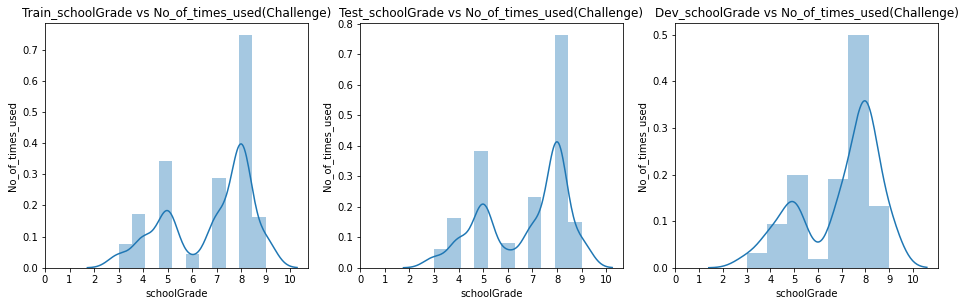

Easy dataset Analysis ...............


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

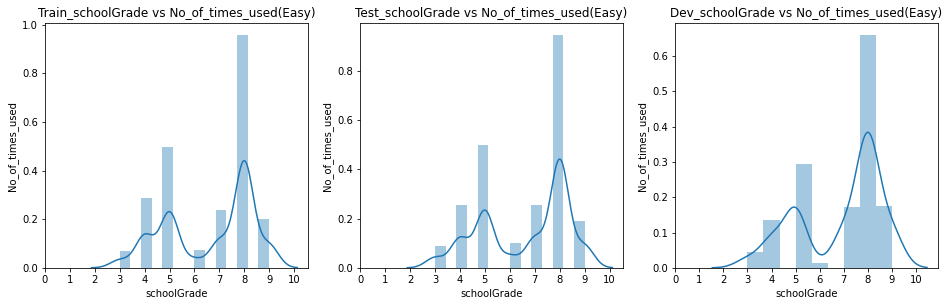

In [ ]:
plot_subplot_bar("_multiple_main_challenge[\"schoolGrade\"]","Challenge")

plot_subplot_bar("_multiple_main_easy[\"schoolGrade\"]","Easy")

### Observation
1.most of the time of each dataset school grade 8 is used.

2.2nd most used is school grade 5 of each dataset.

#### 3.3.2  ExamName Analysis

easy dataset Analysis ...............


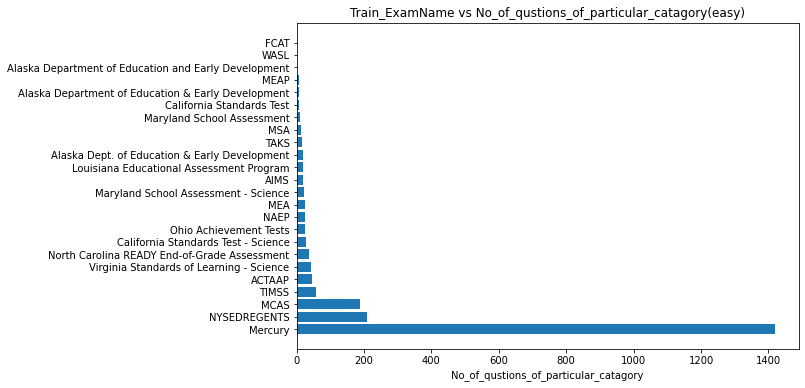

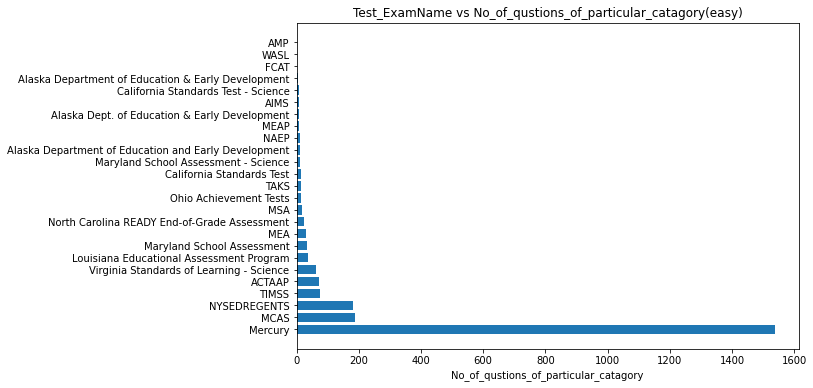

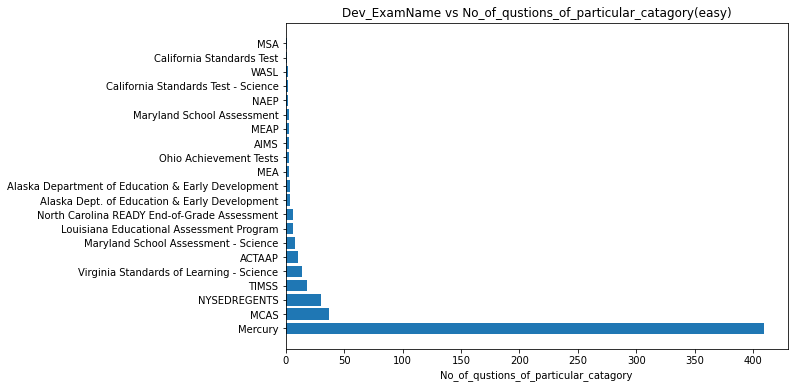

In [ ]:
Exam_graph("easy") 

challenge dataset Analysis ...............


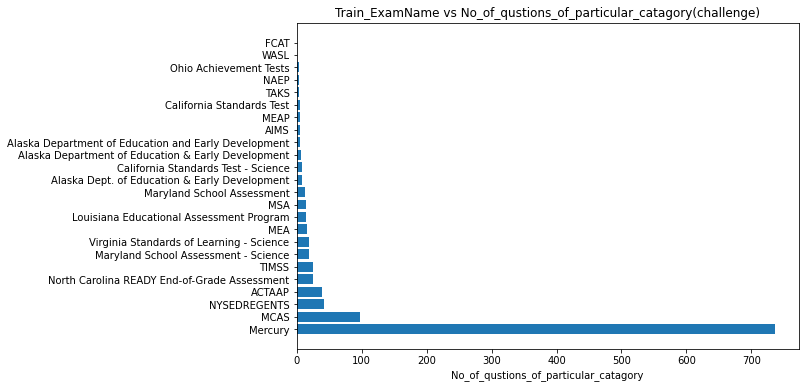

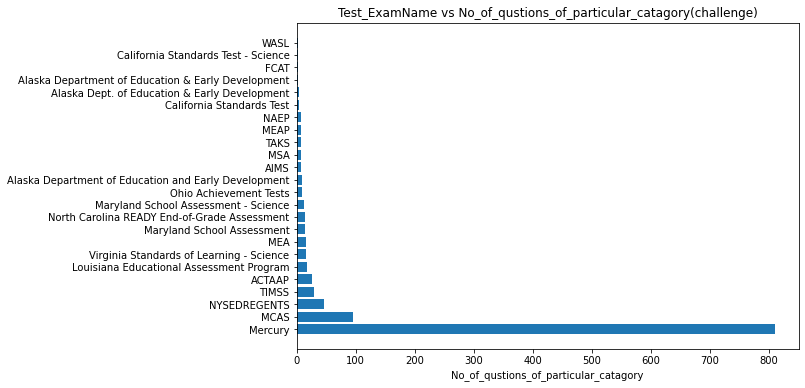

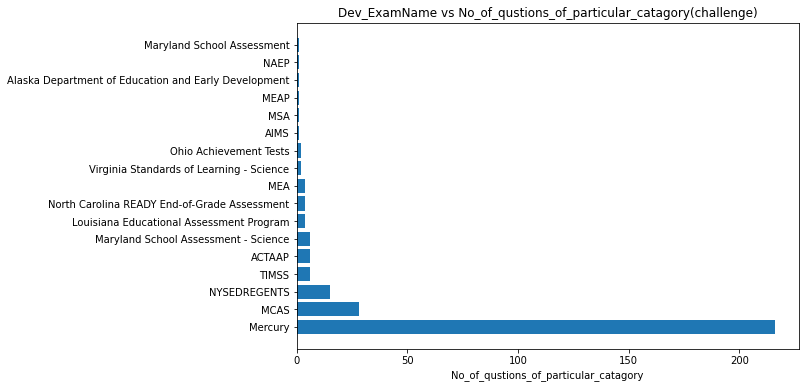

In [ ]:
Exam_graph("challenge") 

### Observation 
1.Most of the question of each dataset are taken from mercury Exam. 

2.From the other exam very question's are taken in  each dataset.

#### 3.3.3 Year_graph

easy dataset Analysis ...............


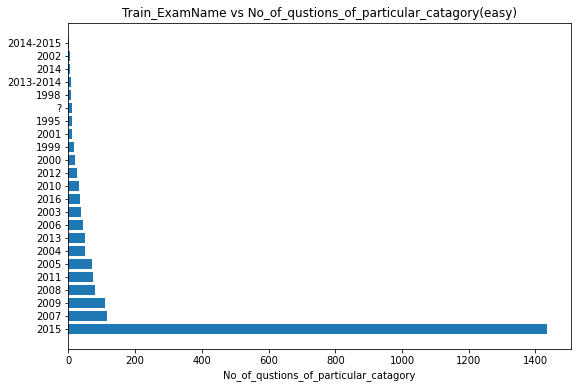

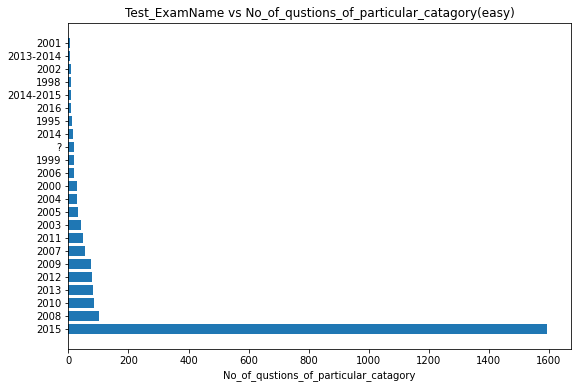

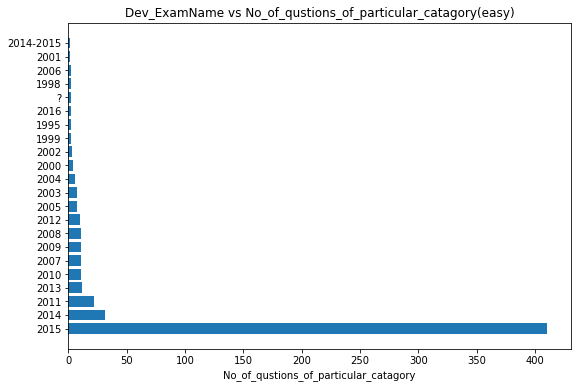

In [ ]:
Year_graph("easy") 

challenge dataset Analysis ...............


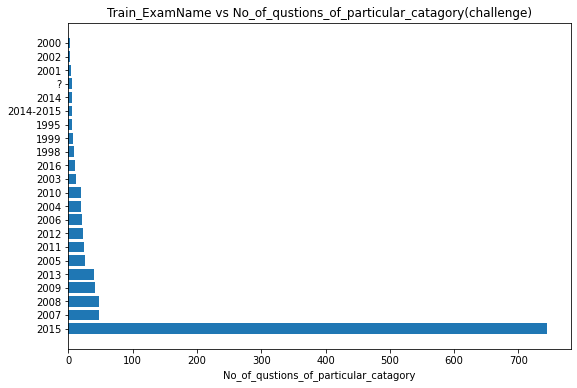

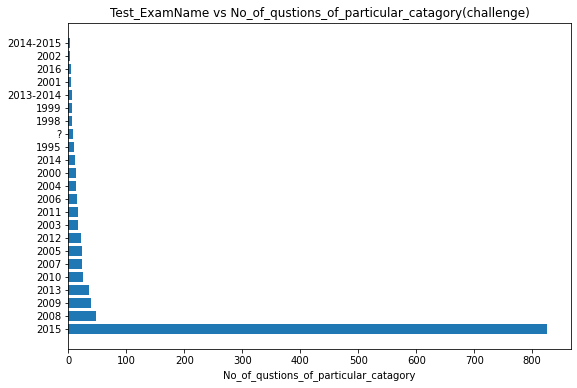

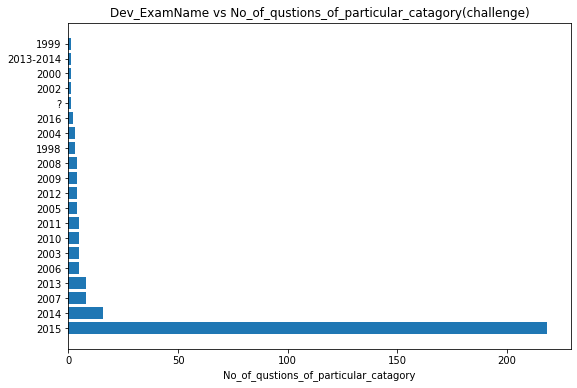

In [ ]:
Year_graph("challenge") 

### Observation
1. most of the question of each dataset is from year 2015.

2. Very few question are there from other year in each dataset.

#### 3.3.4  Questions

In [ ]:
Train_multiple_answers_easy['question'].iloc[0]

'Which factor will most likely cause a person to develop a fever?'

In [ ]:
from collections import Counter
length_of_question = []
for question_ in Train_multiple_answers_challenge['question']:
    length_of_question.append(len([i for i in question_.split()]))
sorted_x = sorted(dict(Counter(length_of_question)).items(), key=lambda kv: kv[0])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


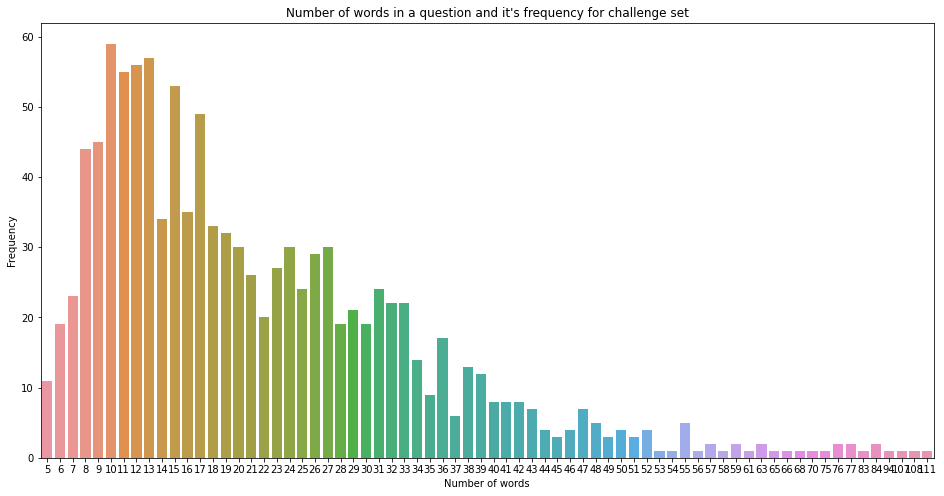

In [ ]:
plt.figure(figsize=(16,8))
plt.title("Number of words in a question and it's frequency for challenge set")
sns.barplot([i[0] for i in sorted_x],[i[1] for i in sorted_x])
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()

In [ ]:
from collections import Counter
length_of_question = []
for question_ in Train_multiple_answers_easy['question']:
    length_of_question.append(len([i for i in question_.split()]))
sorted_x = sorted(dict(Counter(length_of_question)).items(), key=lambda kv: kv[0])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


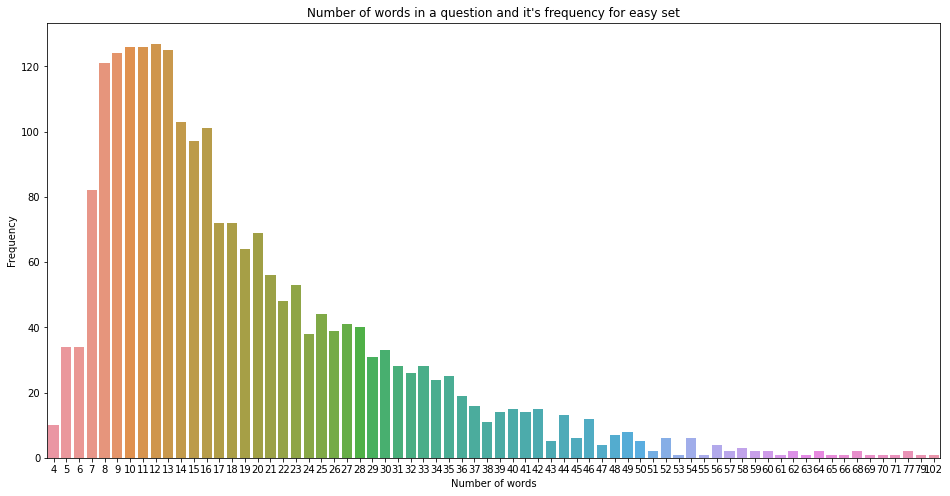

In [ ]:
plt.figure(figsize=(16,8))
plt.title("Number of words in a question and it's frequency for easy set")
sns.barplot([i[0] for i in sorted_x],[i[1] for i in sorted_x])
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()

Observations:

(1) In easy train part most of the questions of length less than 100.

(2) In challenge train part there are many questions with large length.


#### 3.3.5 Answer

easy dataset Analysis ...............
challenge dataset Analysis ...............


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

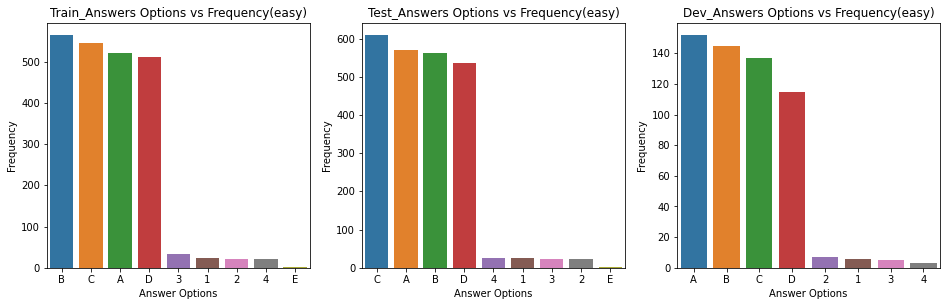

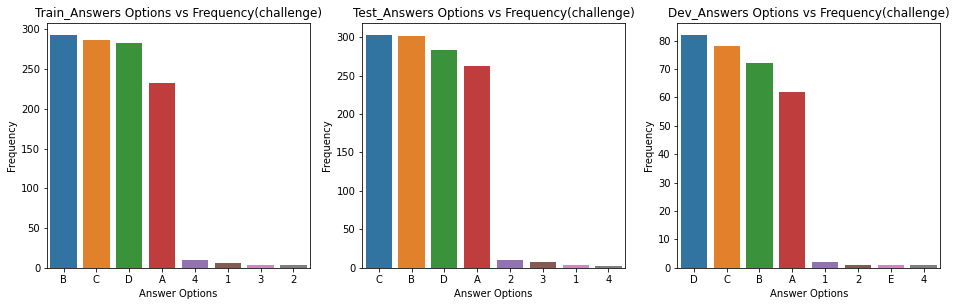

In [ ]:
Answer_graph("easy")
Answer_graph("challenge")

Observations:

(1) There are some questions in easy set which contain 'E' as an option.

(2) Challenge set does not contain any question with 'E' as an opiton.

(3) Questions with answers in format of 1234 are very low as compared to the ABCD format questions.

## 4.Data Cleaning 

In [ ]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]


In [ ]:
import re
proceesed_data = process_questions("challenge")  
Train_multiple_main_challenge['question'] = proceesed_data[0]
Test_multiple_main_challenge['question'] = proceesed_data[1]
Dev_multiple_main_challenge['question'] = proceesed_data[2]

#################################################3

proceesed_data = process_questions("easy")  
Train_multiple_main_easy['question'] = proceesed_data[0]
Test_multiple_main_easy['question'] = proceesed_data[1]
Dev_multiple_main_easy['question'] = proceesed_data[2]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
Test_multiple_main_easy.shape

(2376, 17)

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
from nltk.stem.wordnet import WordNetLemmatizer
Corpous_processed = Corpous_Processing(Sampled_Corpous_data)
print("Corpous processing done....")
processed_word_main = ""
question_list = []
count = 0
for question in tqdm(Corpous_processed):
    count+=1
    processed_word_main = ""
    for word in question.split():
        processed_word = WordNetLemmatizer().lemmatize(word,'v')
        processed_word = processed_word+" "
        processed_word_main += processed_word
    processed_word_main = processed_word_main.strip()    
    question_list.append(processed_word_main) 

  0%|          | 0/10000 [00:00<?, ?it/s]

Corpous processing done....


  0%|          | 0/10000 [00:00<?, ?it/s]